# EXPLORATION_10.뉴스 요약봇 만들기
## 프로젝트: 뉴스기사 요약해보기

## Step 1. 데이터 수집하기
- 데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용
https://github.com/sunnysai12345/News_Summary

In [1]:
#**사용할 라이브러리**
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**데이터 다운로드**

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

**데이터 확인**

In [3]:
data.sample(10)

,headlines,text
46906,3D-printed clip-on device turns smartphone int...,Researchers have developed a 3D-printed clip-o...
68874,Police forced to clarify as fake dead body pro...,A fake bloodied dead body stuck under a garage...
9425,"Pilot flies mother, grandmother on 1st flight,...","An IndiGo pilot from Chennai, Pradeep Krishnan..."
87354,Google founder making biggest aircraft at Ã¢Â...,Google Co-founder Sergey Brin is reportedly bu...
46169,Railways' delayed projects cost overrun of Ã¢Â...,A total of 213 projects of the Indian Railways...
12582,Indulging me with various looks: Sonali on pic...,"Sonali Bendre, who is currently undergoing tre..."
36444,Cello Pens maker moves Bombay HC against forme...,Cello Pens maker BIC Group has moved the Bomba...
68447,"No compromise in fighting corruption, have no ...",Asserting that there will be no compromise in ...
65528,Govt plans free work for poor as criteria for ...,The union government is planning to include fr...
57043,Pak province shuts 1000 govt schools over low ...,Authorities in Pakistan's Khyber Pakhtunkhwa p...


**정리**
- 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어 있다.
- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다.
- 추출적 요약을 하는 경우에는 오직 text열만을 사용한다.

## Step 2. 데이터 전처리하기 (추상적 요약)
### (1) 데이터 정리하기
- 빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터를 먼저 솎아낼 것이다.

#### 1) 중복 샘플과 NULL 값이 존재하는 샘플 제거
- 우선 데이터의 중복 샘플 유무를 확인해 본다.

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


**결과**
- 중복을 제외한다면 text에는 98,360개, headlines에는 98,280개의 유니크한 데이터가 존재한다.
- Text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야한다.

#### 2)데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거

In [5]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


**정리**
- 만약 데이터 Null 값을 가지는 샘플이 있었다면, drop_duplicates()가 중복된 Null들을 지워주기는 하겠지만, 여전히 Null 값 한 개가 어딘가 남아있을 수 있다.
- 데이터에 Null 값이 남아있는지 볼것이다.

#### 3)데이터프레임에 Null 값이 있는지 확인
**방법은 .isnull().sum()을 사용하면 알아볼 수 있다.**

In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


**결과**
headlines과 text에 Null값이 없다.

#### 4) 데이터 정규화와 불용어 제거

In [7]:
#데이터의 정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


**정리**
- 정규화 준비까지 마쳤다.
- 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재한다. 이를 불용어(stopwords)라고 한다. 
- 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있다. 
- 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 것이다.

In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

**결과**
- NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개 이다.

**이제 해야할 것**
- 이를 사용하여 불용어를 제거할 것이다.
- 이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 것이다.
- 함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 headlines  전처리할 때는 호출하지 않을 예정이다.
-  Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines에는 남아 있는 게 더 좋을 것 같다.

**이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가한다**

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

**전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 를 만들어 함수를 호출해본다.**

In [10]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


**결과**
- 결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었다. 
- 또한 (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다. 
- 특수문자가 제거되면서 영어만 남았다.
- 이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해볼것이다.
- 이때, Text의 경우에는 불용어를 제거한다.
- Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해야한다.
- 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해본다.

In [ ]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print(clean_text[:5])


clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print(clean_headlines[:5])

**멀티프로세싱을 사용**
- 위 코드와 같이 싱글 프로세스로 실행하면 데이터 전처리 하는데 꽤나 많은 시간이 소요된다.
- 따라서 멀티프로세싱을 활용하여 별도의 프로세스를 생성하여 병렬처리하면 CPU수에 비례하여 획기적으로 소요 시간을 줄일 수 있다.

In [11]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

187.62548565864563  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

- 이제 headlines에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어준다.
- 이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋다.
- 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있을 수 있다. 이렇게 되면 샘플 자체가 빈 값을 가지게 된다
- 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장 할 것이다. 그리고 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [13]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

**이전과 같이 .isnull().sum()을 사용해서 Null 값이 생겼는지 확인**

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

**결과**
- headlines과 text 모두  Null 값이 0으로 나옴

### (2)훈련데이터와 테스트데이터 나누기
#### 1) 샘플의 최대 길이 정하기
- 필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례이다.

**text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화한다.**

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


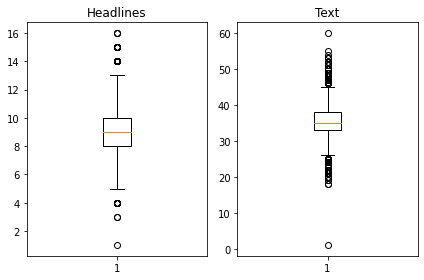

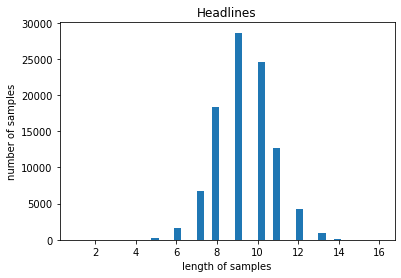

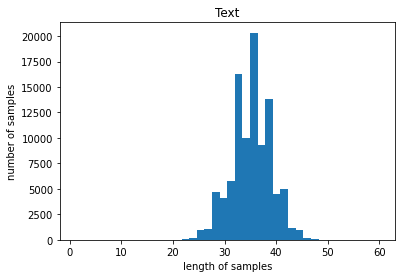

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**결과**
- 위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 된다.
- 위에서부터 차례대로 그래프는 각각 요약과 실제 텍스트의 길이 분포, 요약본 샘플 길이별 개수, 실제 텍스트 샘플 길이별 개수를 나타내고 있다.

**Text**
- 최소 길이가 1, 최대 길이가 60
- 하지만 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 20~50내외의 길이를 가진다는 것을 확인할 수 있다.

**Headlines**
- 최소 길이가 1, 최대 길이가 16
- 평균 길이가 9로 Text에 비해 상대적으로 길이가 매우 짧다.
- 그래프로 봤을 때에도 대체적으로 5~13내외의 길이르 가진다는 것을 확인할 수 있었다.


**이로부터 text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해본다**

In [59]:
text_max_len = 60
headlines_max_len = 16

- 각각 60과 16로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 된다.

**훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해 본다.**

In [60]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

**이렇게 만든 함수를 text와headlines 에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있다**

In [61]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997449212914503
전체 샘플 중 길이가 16 이하인 샘플의 비율: 0.9999898375016514


**정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제**

In [62]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98149


#### 2) 시작 토큰과 종료 토큰 추가하기
- 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 것이었다.
- seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다.
- 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 것이다.
**-디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했다.**
- 두 개의 문장 모두 headlines 열로부터 만들 것이다.

In [63]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,news_summary,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad's Online Power Learning has powered 3 l...,sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Users get one CRED coin per rupee of bill paid...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,The match witnessed India getting all out for ...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","Also, customers have options to insure against...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...,"sostoken Have known Hirani for yrs, what if Me...","Have known Hirani for yrs, what if MeToo claim..."


**디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄것이다.**

In [64]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 3) 훈련 데이터와 테스트 데이터를 분리

**훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 코딩으로 진행을 할 것이다.**

**우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어준다.**

In [65]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[74927 75546 64526 ... 58953 43238 84704]


**- 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이된다.**

In [66]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

**- 이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄것이다.**
**- 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄것이다.**

In [78]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19629


**이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할 것이다.:표시의 위치에 주의해야 한다**

In [79]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78520
훈련 레이블의 개수 : 78520
테스트 데이터의 개수 : 19629
테스트 레이블의 개수 : 19629


**결과**

**훈련 데이터와 테스트 데이터가 각각 78,520개와 19,629개로 잘 분리된 것을 볼 수 있다.**


### (3) 정수 인코딩
####  1) 단어 집합(vocabulary) 만들기 및 정수 인코딩
- 이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야한다. 
**- 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요하다. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현한다. **
- 훈련 데이터에 대해서 단어 집합을 만들어볼것이다.
**- 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들줄 것이다.**
**Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.**

In [80]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

**등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼것이다.**
**src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.**

In [81]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90939
등장 빈도가 6번 이하인 희귀 단어의 수: 66235
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24704
단어 집합에서 희귀 단어의 비율: 72.83453743718317
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7233927428905775


**위 결과의 정보 해석**
- encoder_input_train에는 9만여 개의 단어가 있다.
- 등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 무려 72% 이상을 차지한다.
- 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 2.72%밖에 되지않는다
- 그리고 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다. 
- 위에서 이를 제외한 단어 집합의 크기를 2만여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 20,000으로 제한해 볼것이다.
**- 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.**

In [82]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 2000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

- texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다.
- 현재 단어 집합의 크기를 20,000으로 제한했으니까 이제 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [83]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[111, 8364, 2587, 8, 10, 11, 14, 909, 203, 3, 1644, 7, 17, 584, 381, 2927, 2587, 19, 14, 591, 678, 5382, 1042, 2, 60, 2, 4967, 171, 582, 248, 835, 96, 26, 2, 678, 90, 11, 429, 14, 30, 8364, 63, 10, 11, 24, 111, 819, 530, 137, 309, 132, 3737, 3, 582, 248, 835], [566, 643, 38, 2138, 11, 252, 455, 178, 11067, 549, 1287, 480, 488, 58, 6867, 7658, 8, 10, 205, 11, 128, 13, 3, 1618, 2257, 11, 1, 41, 6, 252, 455, 178, 7194, 4, 559, 2754, 7658, 10, 11, 87, 1, 2754, 3639, 21, 178, 285, 62, 5, 1, 11904, 9814, 6, 3, 1813, 16, 3, 778, 235, 5, 4358], [3, 2785, 18267, 19187, 33, 2202, 1, 2893, 88, 294, 9, 1, 194, 3989, 19187, 8, 32, 611, 65, 9, 798, 2351, 22, 160, 307, 107, 8365, 57, 4, 1407, 21, 13, 20, 343, 15541, 485, 6, 2971, 16, 117, 126, 208, 486, 5125, 1, 526, 4387, 8, 32, 1570, 15, 1, 3515, 3363, 1367]]


- 이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있다.
- headlines 데이터에 대해서도 동일한 작업을 수행할것이다
**- 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산할 것이다**

In [84]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

- 제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.
- 이는 tar_tokenizer.word_index에 저장되어있다.

**tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼것이다.**

In [85]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40695
등장 빈도가 5번 이하인 희귀 단어의 수: 29397
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11298
단어 집합에서 희귀 단어의 비율: 72.23737559896793
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.147379281347277


**정리**
- 등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 72%를 차지하고 있다.
- 아까 했던 것과 동일하게 이 단어들은 모두 제거할것이다.
- 어림잡아 10000을 단어 집합의 크기로 제한할것이다. 

In [86]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 221, 227, 815, 7, 52, 860, 16, 23, 133, 123, 5467], [1, 146, 133, 2323, 267, 125, 509, 1558, 171], [1, 141, 127, 3008, 1559, 197, 6208, 32, 404, 7, 376], [1, 3639, 972, 1490, 3, 873, 4, 444, 20, 4333, 3, 540], [1, 5711, 9397, 1277, 4334, 4, 1353, 1371]]
target
decoder  [[221, 227, 815, 7, 52, 860, 16, 23, 133, 123, 5467, 2], [146, 133, 2323, 267, 125, 509, 1558, 171, 2], [141, 127, 3008, 1559, 197, 6208, 32, 404, 7, 376, 2], [3639, 972, 1490, 3, 873, 4, 444, 20, 4333, 3, 540, 2], [5711, 9397, 1277, 4334, 4, 1353, 1371, 2]]


**결과**
- 정상적으로 정수 인코딩 작업이 끝났다.
- 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 500이 넘는 숫자들은 존재하지 않는다

**훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장할 것이다. 이 샘플들은 모두 삭제할 것이다.**.

In [87]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78520
훈련 레이블의 개수 : 78520
테스트 데이터의 개수 : 19628
테스트 레이블의 개수 : 19628


**결과**
훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인할 수 있다.

#### 2) 패딩하기
- 텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 한다. 
- 아까 정해두었던 최대 길이로 패딩 해 줄 것이다.
**- 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄것이다.**

In [88]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

**이제 학습에 필요한 데이터 전처리가 모두 끝났다!!**

### (4) 모델 설계하기
- 우선 함수형 API를 이용해서 인코더를 설계해 볼것이다.

In [89]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 임베팅 벡터의 차원은 128로 정의 하고, hidden state의 크기를 256으로 정의했다.
- hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다.
- 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 된다.
- 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다. 
- 인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다.
**해야하는 부분**

- hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있다.
- 3개의 층을 지나서 **인코더로부터 나온 출력 벡터는 디코더로 보내줘야한다.**


#### 1) 디코더를 설계

In [90]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

**정리**

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다. 
**하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야한다.**

#### 2)디코더의 출력층을 설계

In [91]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

**정리**
- 디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야한다. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있다.

- 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq이다.그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있다. 즉, 바로 어텐션 메커니즘이다.

## Step 2. 어텐션 메커니즘 사용하기 (추상적 요약)
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이다,
어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼것이다.


**아래의 코드를 수행하여 깃허브에 공개돼 있는 어텐션 함수를 다운로드**

In [92]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

**결과**
이제 경로에 attention.py 파일이 생겼으니, 어텐션 메커니즘을 사용할 준비가 되었다.

### (1)설계한 디코더의 출력층을 다음과 같이 수정

In [93]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

**정리**

**위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고,텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다.**

### (2) 모델 훈련하기
- 설계한 모델을 가지고 훈련을 진행해볼것이다.

In [94]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=30)

Epoch 1/30
307/307 [==============================] - 298s 936ms/step - loss: 4.8621 - val_loss: 4.1130
Epoch 2/30
307/307 [==============================] - 286s 933ms/step - loss: 4.0668 - val_loss: 3.7922
Epoch 3/30
307/307 [==============================] - 286s 932ms/step - loss: 3.7339 - val_loss: 3.5571
Epoch 4/30
307/307 [==============================] - 286s 932ms/step - loss: 3.5029 - val_loss: 3.4092
Epoch 5/30
307/307 [==============================] - 286s 932ms/step - loss: 3.3293 - val_loss: 3.2911
Epoch 6/30
307/307 [==============================] - 287s 934ms/step - loss: 3.1807 - val_loss: 3.1896
Epoch 7/30
307/307 [==============================] - 285s 927ms/step - loss: 3.0529 - val_loss: 3.1195
Epoch 8/30
307/307 [==============================] - 283s 922ms/step - loss: 2.9496 - val_loss: 3.0540
Epoch 9/30
307/307 [==============================] - 280s 913ms/step - loss: 2.8551 - val_loss: 3.0061
Epoch 10/30
307/307 [==============================] - 278s 905m

**'조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할**
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

-위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있다.
-EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있다..

**이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화**

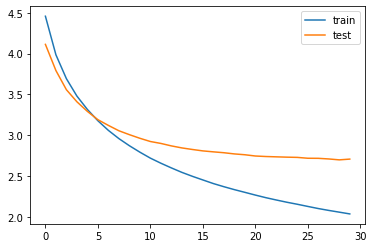

In [95]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### (3)인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해준다

In [96]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다
**훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비한다. 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야한다.** 

#### 1) 코더 모델과 디코더 모델을 분리해서 설계

In [100]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#### 2) 어텐션 메커니즘을 사용하는 출력층을 설계

In [101]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

#### 3)인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어준다

In [102]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### (4) 모델 테스트하기

- 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다.
**- 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어 본다.**
- 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 것이다.

In [103]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

#### 1) 테스트 데이터 약 80개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [104]:
for i in range(80, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : the congress to the pm narendra modi led bjp bjp chief amit shah on sunday said the congress has no leader no strategy and no principle shah who was addressing a rally ahead of the chhattisgarh assembly elections added the congress always opposed chhattisgarh and it was only after atal bihari vajpayee became prime minister that the state was formed 
실제 요약 : congress has no leader and no claims amit shah 
예측 요약 :  no trust motion against bjp in lok sabha congress


원문 : e will managing company guardian is said to make a four day work week permanent for employees after a two month trial for the same turned out to be a success over 240 company employees worked for eight hours for four days but were paid for five days their work life balance increased by 24 percentage points during the trial 
실제 요약 : nz firm to make 4 day work week permanent after success 
예측 요약 :  jio to lay off 20 000 employees for work in one months


원문 : pakistan's president mamnoon hussain has signed an ordinanc

**결과**
- 많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보인다.
- 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있다

## Step 3. Summa을 이용해서 추출적 요약해보기
### (1) 패키지 설치

In [105]:
import requests
from summa.summarizer import summarize

#### 1)summarize 사용하기
**Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아본다.**
text (str) : 요약할 테스트.
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

- Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다.

**비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여본다. 원문의 0.5%만을 출력하도록 설정했다.** 

In [106]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data['news_summary'] = data['text'].apply(lambda x : summarize(x, ratio = 0.5))
data.head()

,headlines,text,news_summary
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...


In [107]:
for i in range(50, 100):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("예측 요약 :", data['news_summary'][i])
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

## 회고 
**추상적 모델 훈련과정**
- 추상적인 모델 훈련 과정에 text의 최대 길이와 headlines의 적절한 최대 길이를 어떻게 정하는 냐에 따가서 나오는 결과 값이 달라진다는 것을 알았다.
- 처음에 text의 최대 길이를 30, headlines의 적절한 최대 길이를 8로 했을 때는  epochs를 하나씩 진행하는데 빠르면 4초 만에 결과 값이 나왔었다. 최대 길이를 짧게하면 모델 훈련은 빠르게 진행 할 수 있지만 요약 된 결과물을 봤을 때 몇게의 댠어만 나열 되어 있다 보니 어떤 내용을 말하는지 전혀 알 수 없었다. 그래서 다시 최대 길이를 높여서 진행하였다. 높여서 진행한 결과 학습하는 시간이 하나당 대략 3분정도씩 걸렸다. 총 30개의 epochs를 돌렸을 때 대략 2~3시간 정도 걸렸다. 그래도 진행 될 때 마다 loss률이 줄어 주는 것을 확인할 수 있었다. 
처음 최대 길이를 30,8로 진행한 것 보다 결과는 만족스럽게 나왔다. 

**추철적 모델**

파일을 불러오는 부분에서 어떻게 해야할 지 어려움이 있었다. 추상적 추출 보다는 결과 값을 빠르게 확인 할 수 있었다. 내용을 확인한 결과 요약도 잘 되어 있었다. 